##### Multiple Exponpow pdfs $p_S(s)$ and multiple click through probabilities $p_C$

In [139]:
import os
import numpy as np
import pandas as pd
from bid.generate_data import generate_datasets
from bid.get_pdfs import get_ps_pw_from_data, get_ps_pw_analytical
from bid.optimization import optimize

from main import get_summary

In [129]:
distribution_type = 'exponpow'

I = 3
J = 2
Nc = 100
N_scale = 100000

np.random.seed(11)
N = np.random.randint(low=1, high=10, size=(I * J,)) * N_scale

# user click through probabilities
#
pc = np.arange(1, J + 1, 1) * 0.005
pc = np.repeat(pc, I)

print('\n\nCheck if N*pc >> Nc\n')
print('N*pc:      \t {0}'.format(int((N * pc).sum())))
print('Nc:        \t {0}'.format(Nc))
print('N*pc >> Nc \t {0}'.format((N * pc).sum() >= 10 * Nc))
print('\n\n')

# auction winning bid distributions
#

if distribution_type == 'exponpow':
    bs = np.arange(0, I)*2 + 2
    dist_params_list = [dict(b=b) for b in bs]
else:
    distribution_type = 'expon'
    alphas = np.arange(1, I + 1) * 0.1
    dist_params_list = [dict(scale=1. / a) for a in alphas]

sizes = [sum([N[j * I + i] for j in range(J)]) for i in range(I)]

# initial value
#
x0 = np.ones(shape=(I * J,)) * 0.001

all_dfs = dict()

for case in ['fct analytical', 'fct inferred from data']:
    if case == 'fct inferred from data':
        datasets = generate_datasets(distribution_type, dist_params_list, sizes)
        ps, _, pw = get_ps_pw_from_data(datasets, J)
    else:
        ps, _, pw = get_ps_pw_analytical(J, distribution_type, dist_params_list)

    res = optimize(x0, pw, N, pc, Nc)
    all_dfs[case] = get_summary(res, np.tile(dist_params_list, J), pc, N)




Check if N*pc >> Nc

N*pc:      	 18500
Nc:        	 100
N*pc >> Nc 	 True





/Users/A.IVA/opt/anaconda3/envs/everything/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/Users/A.IVA/opt/anaconda3/envs/everything/lib/python3.7/site-packages/scipy/optimize/_trustregion_constr/projections.py:182: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


In [130]:
import copy

df1 = all_dfs['fct analytical'].set_index(['dist_params', 'N_group', 'pc']).copy(deep=True)
df2 = all_dfs['fct inferred from data'].set_index(['dist_params', 'N_group', 'pc']).copy(deep=True)

df1.columns = df1.columns.map(lambda x: x + ' (fct analytical)')
df2.columns = df2.columns.map(lambda x: x + ' (fct inferred from data)')

df = df1.join(df2)
df['dx'] = df['x (fct analytical)'] - df['x (fct inferred from data)']
df['rel err'] = abs(df['dx'])/df['x (fct analytical)']
df

,,,x (fct analytical),x (fct inferred from data),dx,rel err
dist_params,N_group,pc,,,,
{'b': 2},100000,0.005,0.095343,0.094953,0.000389,0.004085
{'b': 4},200000,0.005,0.114412,0.117126,-0.002714,0.023718
{'b': 6},800000,0.005,0.122585,0.120706,0.001879,0.015330
{'b': 2},200000,0.010,0.190659,0.190809,-0.000150,0.000788
{'b': 4},800000,0.010,0.228825,0.227044,0.001781,0.007782
{'b': 6},300000,0.010,0.245169,0.242125,0.003045,0.012418


In [131]:
df = df.reset_index()

##### Plot results

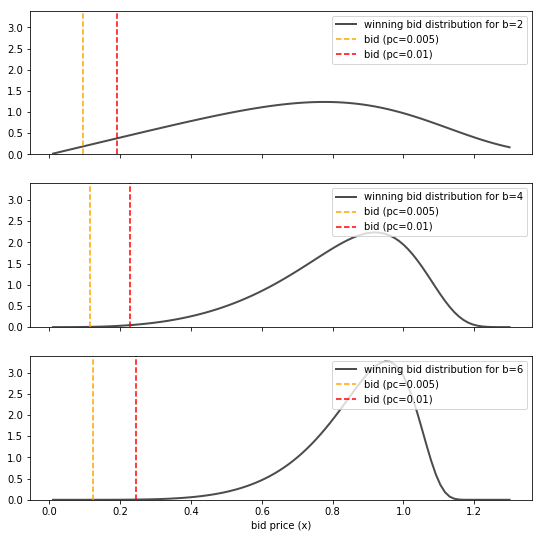

In [134]:
import matplotlib.pyplot as plt
from scipy.stats import exponpow

x = np.linspace(0.01, 1.3, 100)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(9,9))

for b, ax in zip(bs, (ax1, ax2, ax3)):

    ax.plot(x, exponpow.pdf(x, b=b), color='black', linestyle='solid', lw=2, alpha=0.7, label=f'winning bid distribution for b={b}')
    
    for pc, color in zip(df['pc'].unique(), ['orange', 'red']):
        tmp = "{'b': " + str(b) + "}"
        bid = df.loc[(df['dist_params']==tmp) & (df['pc']==pc), 'x (fct analytical)'].values[0]
        ax.axvline(x=bid, color=color, linestyle='--', label=f'bid (pc={pc})')
        ax.set_ylim(bottom=0, top=3.4)
    
    ax.legend(loc="upper right")

ax3.set_xlabel('bid price (x)')
plt.show()

In [140]:
save_path = os.path.join('pdf', 'fig', 'biding_strategy.png')
fig.savefig(save_path, transparent=True, pad_inches=0, bbox_inches='tight')

#####  Single Exponential pdf $p_S(s)$ and single click through probability $p_C$

In [99]:
distribution_type = 'expon'
Nc_list = [50*i for i in range(1, 12, 1)]
dfs = []

for Nc in Nc_list:

    I = 1
    J = 1
    N_scale = int(1e6)

    np.random.seed(11)
    N = np.random.randint(low=1, high=10, size=(I * J,)) * N_scale

    # user click through probabilities
    #
    pc = np.arange(1, J + 1, 1) * 0.005
    pc = np.repeat(pc, I)

    # auction winning bid distributions
    #
    distribution_type = 'expon'
    alphas = np.arange(1, I + 1)
    dist_params_list = [dict(scale=1. / a) for a in alphas]
    
    sizes = [sum([N[j * I + i] for j in range(J)]) for i in range(I)]

    # initial value
    #
    x0 = np.ones(shape=(I * J,)) * 0.001

    all_dfs = dict()

    # for case in ['fct analytical', 'fct inferred from data']:
    for case in ['fct analytical']:
        if case == 'fct inferred from data':
            datasets = generate_datasets(distribution_type, dist_params_list, sizes)
            ps, _, pw = get_ps_pw_from_data(datasets, J)
        else:
            ps, _, pw = get_ps_pw_analytical(J, distribution_type, dist_params_list)

        res = optimize(x0, pw, N, pc, Nc)
        all_dfs[case] = get_summary(res, np.tile(dist_params_list, J), pc, N)
        all_dfs[case]['Nc'] = Nc
    
    dfs.append(all_dfs[case])

/Users/A.IVA/opt/anaconda3/envs/everything/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


In [113]:
df = pd.concat(dfs)
df['x (analytical)'] = np.log(df['N_group'] * df['pc'] / (df['N_group'] * df['pc'] - df['Nc']))
df = df[['dist_params', 'N_group', 'pc', 'Nc', 'x', 'x (analytical)']]
df['dx'] = np.round(abs(df['x'] - df['x (analytical)']), 15)
df.set_index(['dist_params', 'N_group', 'pc'])

Nc         x  x (analytical)   dx
dist_params    N_group pc                                       
{'scale': 1.0} 1000000 0.005   50  0.010050        0.010050  0.0
                       0.005  100  0.020203        0.020203  0.0
                       0.005  150  0.030459        0.030459  0.0
                       0.005  200  0.040822        0.040822  0.0
                       0.005  250  0.051293        0.051293  0.0
                       0.005  300  0.061875        0.061875  0.0
                       0.005  350  0.072571        0.072571  0.0
                       0.005  400  0.083382        0.083382  0.0
                       0.005  450  0.094311        0.094311  0.0
                       0.005  500  0.105361        0.105361  0.0
                       0.005  550  0.116534        0.116534  0.0

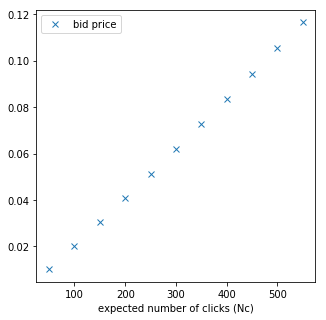

In [127]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5,5))

Ncs = df['Nc'].values
xs = df['x'].values

ax.plot(Ncs, xs, 'x', alpha=1, label=f'bid price')
ax.set_xlabel('expected number of clicks (Nc)')
ax.legend(loc="upper left")

plt.show()